[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import six

from collections import OrderedDict
from radiomics import featureextractor
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()

# Pre-process Images

Image dimensions: (832, 1128)


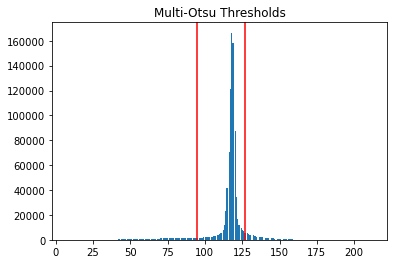

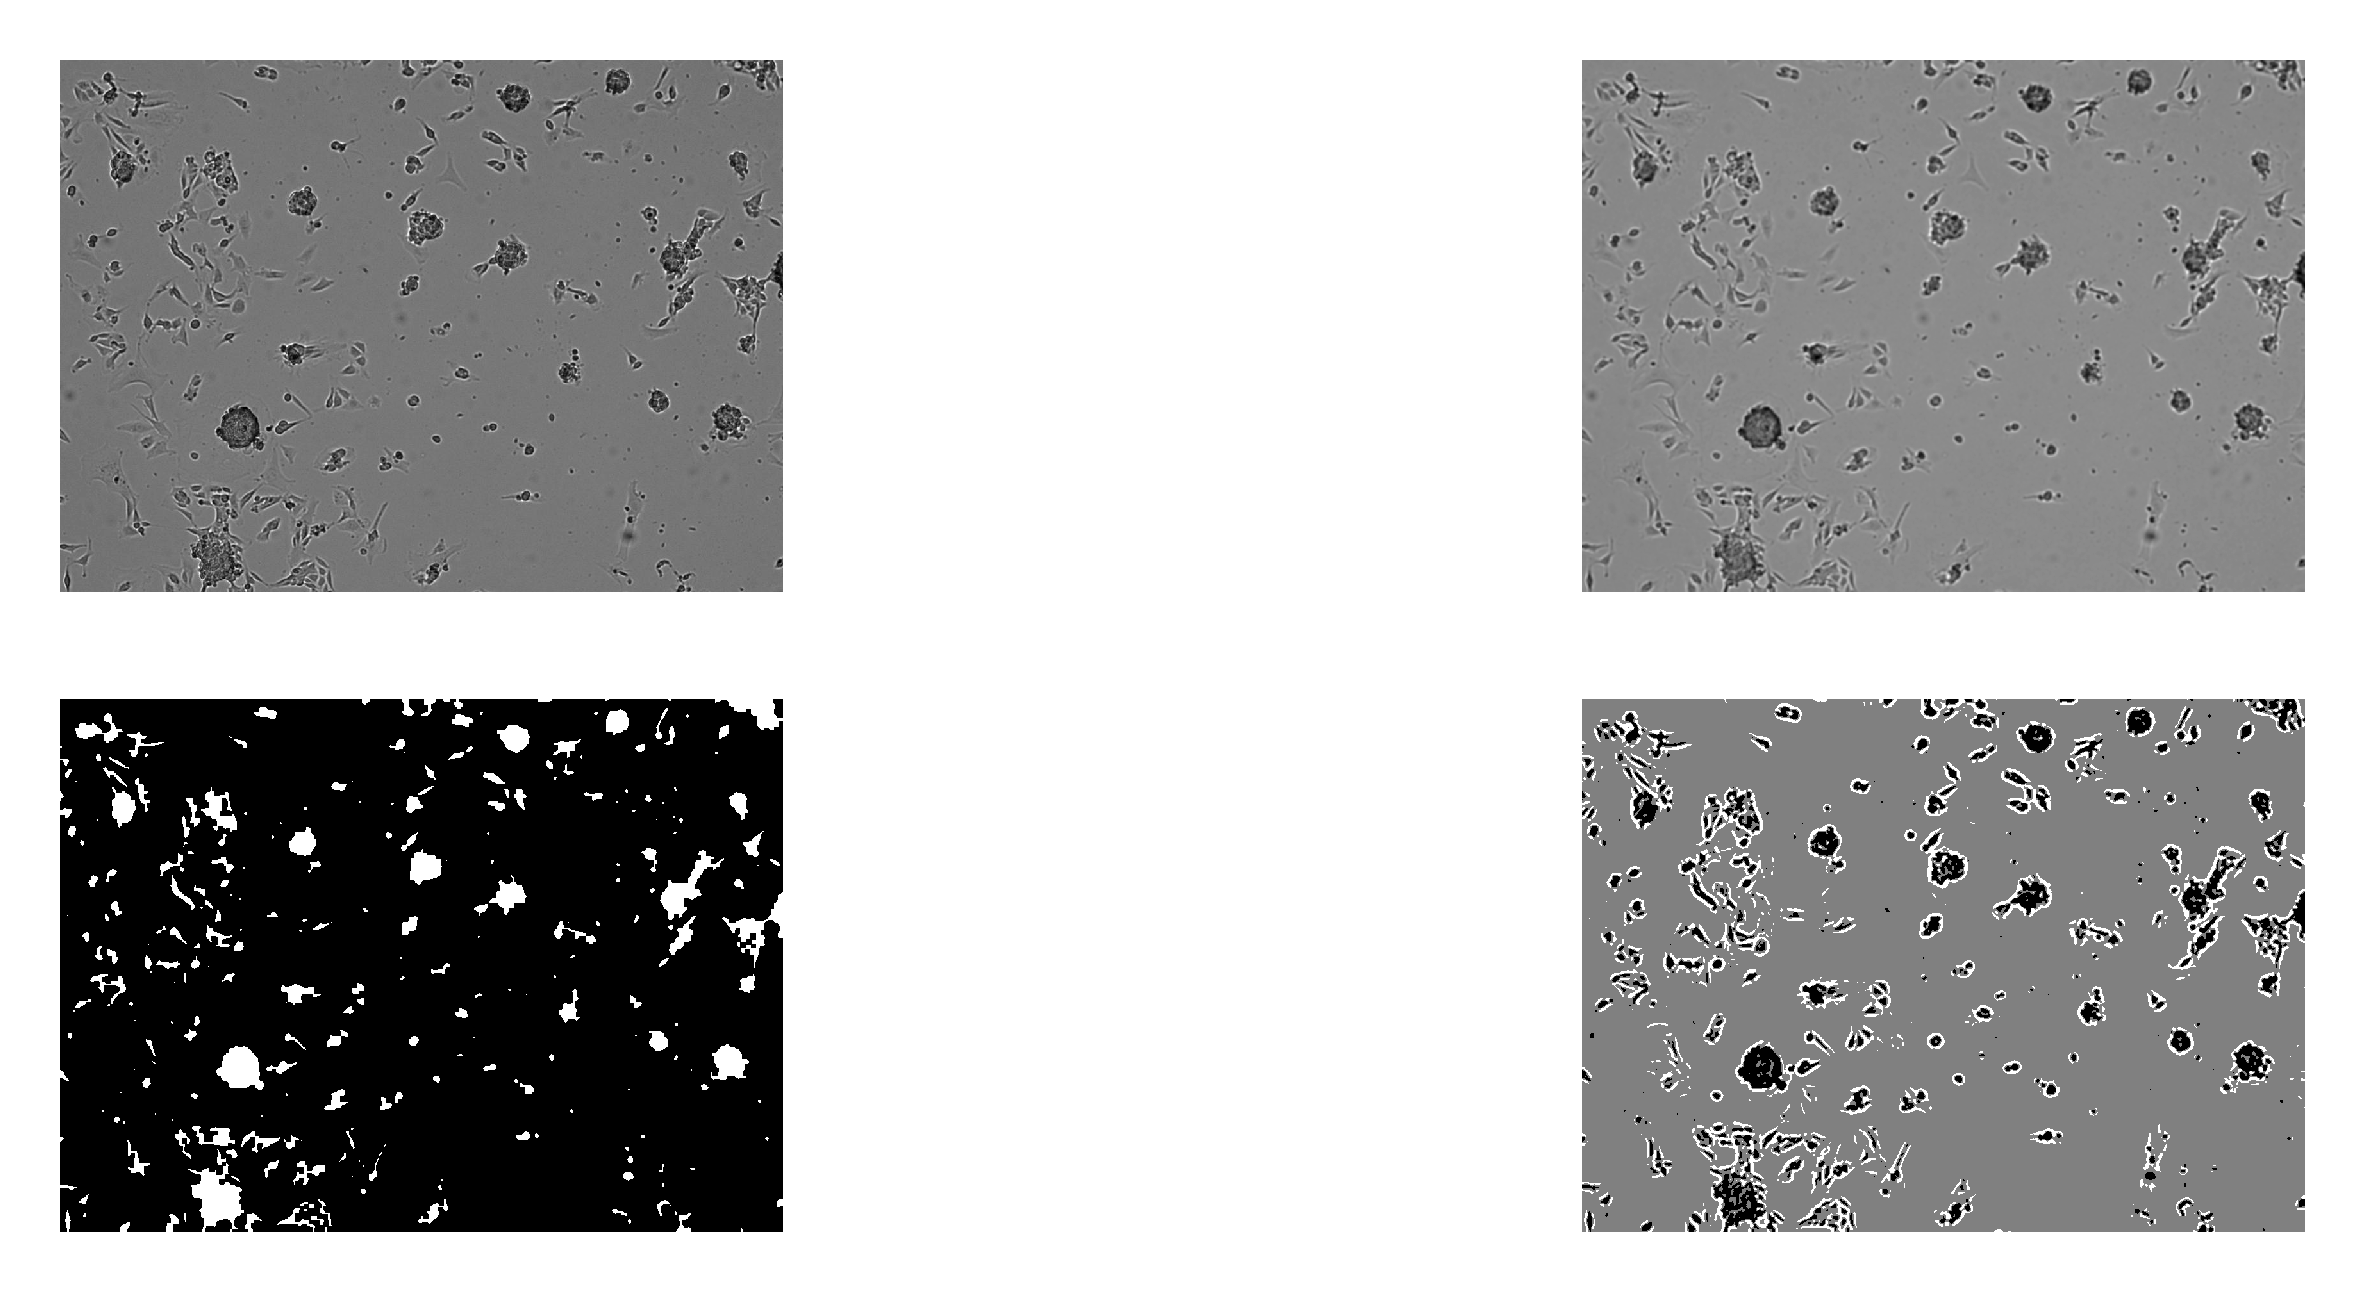

In [2]:
rfp = cv2.imreadmulti('source_images/Control.tif')[1]

raw_image = rfp[0]
print("Image dimensions: " + str(raw_image.shape))

blurred = cv2.GaussianBlur(raw_image,(5,5),cv2.BORDER_DEFAULT)

# Otsu thresholding
threshold, binarized = \
    cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
binarized = np.uint8(blurred < threshold)
binarized = apply_imfill(apply_closure(binarized, kernel_size=7))

# Experiment w/ multi-Otsu
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, binarized, multi_otsu_regions],
                    columns=2, dpi=600)

# Extract Features

In [3]:
# mask = sitk.ConnectedComponentImageFilter().Execute(sitk.GetImageFromArray(binarized))
num_components, labelled, stats, centroids = \
        cv2.connectedComponentsWithStats(binarized, connectivity=8)

features = OrderedDict()

for i in range(1, len(stats)):  # index 0 is the background component
    size = stats[i, -1]
    if size < 100:
        continue
    mask = np.uint8(labelled == i)
    result = extractor.execute(sitk.GetImageFromArray(raw_image),
                               sitk.GetImageFromArray(mask))
    if len(features) == 0:
        features['x'] = [int(centroids[i][0])]
        features['y'] = [int(centroids[i][1])]
        for key, val in six.iteritems(result):
            if key.startswith("original_"):
                features[key] = [val]
    else:
        features['x'] += [int(centroids[i][0])]
        features['y'] += [int(centroids[i][1])]
        for key, val in six.iteritems(result):
            if key.startswith("original_"):
                features[key] += [val]

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

In [4]:
df = pd.DataFrame.from_dict(features)
display(df)

,x,y,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,541,14,40.6,99.0,1543494.0,1.992336268815331,32.0,3.0027828048705403,132.0,18.609529639832672,...,7.451426697607905,0.02640719335750652,4.202819531114777,0.10774410774410774,311.5146484375,1.7560102736578995,0.03263863504882844,5.621088688917894,0.026038882682901113,0.4121581825439436
1,574,10,47.0,112.60000000000002,1994134.0,2.106223262917391,30.0,6.109963950821862,197.0,22.28854614150406,...,5.083622583157956,0.03238163658053974,4.4058222502856825,0.1366906474820144,177.00554016620498,1.577232688947138,0.04042616434260656,8.139297124016329,0.029301852886512277,1.0098916418640356
2,620,7,31.0,85.10000000000001,530756.0,1.844102315529822,35.5,2.636745522400907,121.0,18.672857142857147,...,4.274834290254266,0.04778278573841658,3.8208888513501837,0.15,153.17460317460316,1.8207408183214633,0.05637227174502861,4.3091078274279,0.03963635985006246,0.4463500439753738
3,1087,18,42.0,147.0,22852638.0,2.720523564632071,53.0,3.380458759295933,241.0,32.5326380590341,...,11.816043564257702,0.03309286022980827,5.9666674038709235,0.12299000434593654,220.0853800147336,3.7137930612119066,0.007162634155838685,16.01399036264234,0.0240243406761339,0.29301600351553203
4,321,21,42.900000000000006,121.10000000000002,2936163.0,2.3061548217778136,42.0,3.60289211514153,190.0,25.204365079365086,...,8.210352604304175,0.047642805401747916,4.78758076221763,0.11666666666666667,155.30612244897958,1.4034343486759033,0.027176341177086828,11.5518854261843,0.02538149536458575,0.7153652392947103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,297,815,41.0,138.8,2936488.0,2.5516804792006433,37.0,4.5422348891319055,229.0,29.00070548835944,...,11.776577963746123,0.05252693810738579,5.082641500963339,0.21574344023323616,82.20471146822499,0.9431292330324009,0.02851520518982277,24.20155757033881,0.032251530344928794,1.479402316823237
121,972,819,25.0,135.0,1991770.0,2.5440021012707152,49.0,3.3371218137381815,184.0,30.692819449494404,...,10.979499868363789,0.056292600226492434,4.72216767560568,0.26332288401253917,35.58999433106575,1.8600114302967563,0.031069623622282615,15.229155109353098,0.05427500914742995,0.8034234953033619
122,174,817,59.0,124.60000000000002,2411626.0,1.9804832775575552,23.0,5.815832625760447,195.0,19.239223458402776,...,4.205836098282794,0.06622285880836419,4.453188816197024,0.11073825503355705,278.4536271808999,1.610652841781874,0.029841636187633223,8.589859362456352,0.025777130942408584,0.7712629615385708
123,401,812,74.1,126.30000000000004,1367812.0,1.4495833302663808,14.0,8.944408300923469,210.0,17.380876810156714,...,9.914493363381016,0.056322492504742444,3.7130477796125456,0.14788732394366197,217.51473922902494,0.7307252127904301,0.07823168068252026,6.632580034022149,0.017998195116863284,2.834250662049003


# Clustering

In [5]:
df['label'] = KMeans(n_clusters=2, random_state=0).fit_predict(df.drop(['x', 'y'], axis=1))

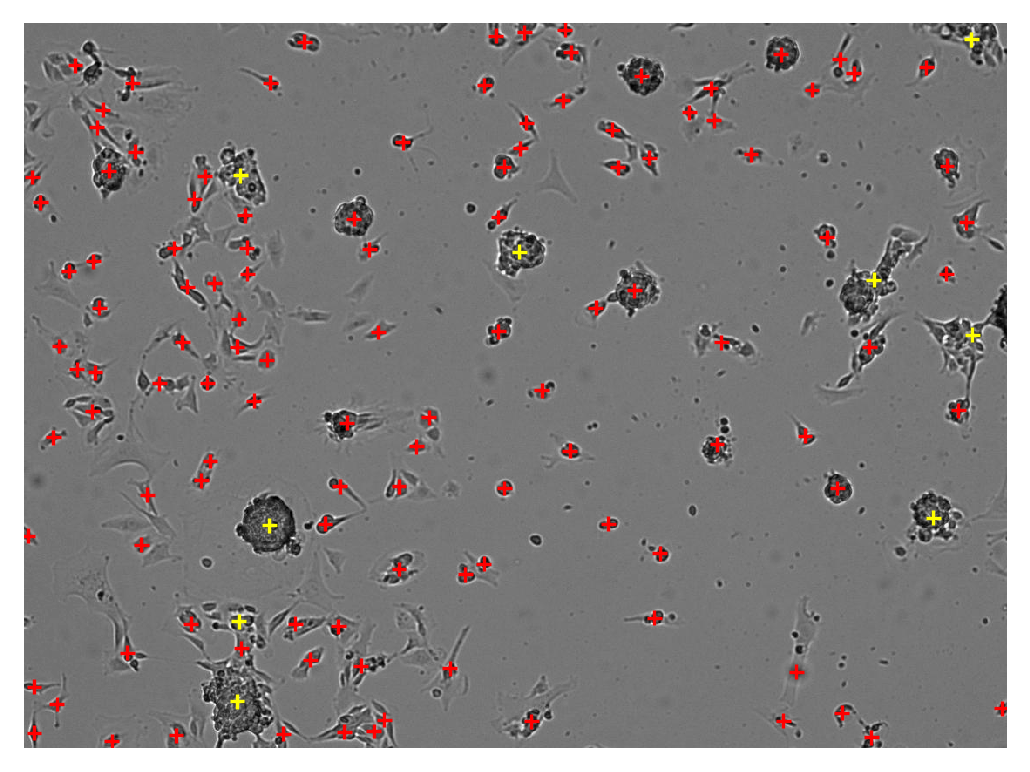

In [6]:
plt.figure(dpi=240)
plt.axis('off')
plt.imshow(raw_image, interpolation='nearest', cmap='gray')
plt.scatter(*zip(*np.array(df[['x', 'y']])), s=20, c=df['label'], marker='+',
            cmap=matplotlib.colors.ListedColormap(['yellow', 'red']), linewidths=1)
plt.show()